In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from mobius import VirtualTarget, ForceField

In [8]:
def plot_logbook(logbook, minimum_score):
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    size_avgs = logbook.select("avg")

    fig, ax1 = plt.subplots(figsize=(15, 5))
    line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    
    line3 = ax1.plot(np.linspace(0, np.max(gen), np.max(gen)), [minimum_score] * np.max(gen), 
             '--', color='green', label='Target fitness')

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, size_avgs, "r-", label="Average Fitness")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2 + line3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper right")
    
    ax1.set_ylim([0, 12])
    ax2.set_ylim([0, 20])

    plt.show()
    

def plot_distribution(logbooks, variable_name, x_labels, min_score=None, fig_name=None):
    i = 0
    max_gen = np.max(logbooks['gen']) + 1
    n_col = len(set(logbooks[variable_name]))
    
    fig, axarr = plt.subplots(1, n_col, figsize=(n_col*6, 12), sharey=True)

    axarr[0].set_ylabel('#Generations', fontsize=30)
    axarr[0].set_yticks(np.arange(0, max_gen + 1, 1.0))
    axarr[0].tick_params(axis='both', which='major', labelsize=20)

    for _, var_group in logbooks.groupby(variable_name):
        gens = []
        failed = 0

        for _, group in var_group.groupby('run'):
            best = group.sort_values(by=['min', 'gen']).iloc[0]
            if min_score is None:
                gen = best['gen'] + 1 if best['min'] <= group['target_score'].values[0] else max_gen
            else:
                gen = best['gen'] + 1 if best['min'] <= min_score else max_gen
            gens.append(gen)

            if gen == max_gen:
                failed += 1

        sns.set_theme(style=None)
        sns.violinplot(y=gens, cut=0, ax=axarr[i])
        sns.stripplot(y=gens, color='black', size=10, ax=axarr[i])
        axarr[i].set_ylim([-0.5, max_gen + .5])
        axarr[i].set_xlabel('%s - (F: %d)' % (x_labels[i], failed), fontsize=30)

        i += 1
    
    if fig_name is not None:
        plt.savefig(fig_name, dpi=300, bbox_inches='tight')

    plt.show()

# Weighted PBIL

In [3]:
class PBIL(object):
    def __init__(self, peptide_length, population_size=96, n_best=48, learning_rate=0.5, sigma=0.25, 
                 mut_prob=0.0, mut_shift=0.00, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._sigma = sigma
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._best_score = 9999

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)

    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                if scores[best_peptide_indices[0]] < self._best_score:
                    self._best_score = scores[best_peptide_indices[0]]
                
                if not np.all(scores[best_peptide_indices] == self._best_score):
                    # Normalize the scores between 0 (best score so far) and the worst in this serie
                    norm_scores = scores[best_peptide_indices] - self._best_score
                    norm_scores /= np.max(scores[best_peptide_indices]) - self._best_score

                    # Use the radial basis function (RBF) kernel
                    # Closest the score is from the best score, greater will be its weight
                    weights = np.exp(-norm_scores**2 / (2 * self._sigma**2))
                else:
                    # All the peptides got the same score as the best score
                    weights = np.array([1] * len(best_peptides[:,i]))
                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                weights = np.flip(weights)
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
                weights = [1.]
            
            for amino_acid, weight in zip(amino_acids, weights):
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += weight * self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])


def evaluate(individual):
    return vt.score_peptides([''.join(individual)])[0],

# Initial testing

In [272]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
minimum_score = vt.score_peptides([vt.target_sequence()])[0]

AAAAAA
[0.]


/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	std    	min    	max    
0  	96    	17.1643	2.98738	9.14043	23.9056
1  	96    	12.6511	3.36517	2.96542	20.5205
2  	96    	8.59056	3.35878	1.90108	16.9212
3  	96    	6.64754	2.99618	1.90108	13.2629
4  	96    	5.44995	2.78134	1.90108	15.7008
5  	96    	4.70118	2.80994	0.950538	14.2845
6  	96    	5.29083	2.93057	0       	12.1911
7  	96    	4.76496	3.27931	0       	14.7622
8  	96    	3.5244 	3.1089 	0       	14.7084
9  	96    	2.58059	2.54419	0       	10.5977


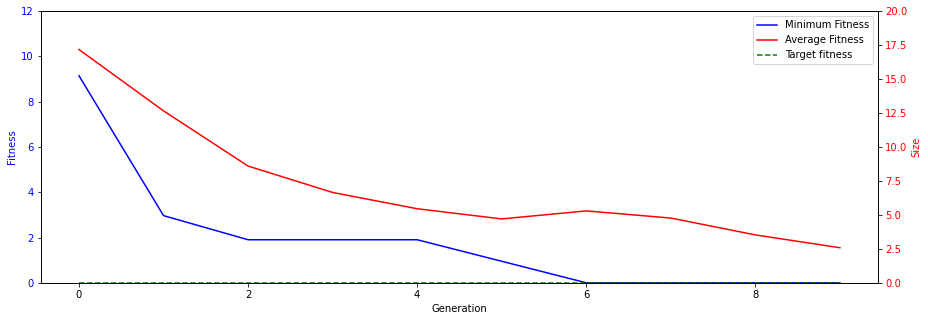

[['A', 'A', 'A', 'A', 'A', 'A'], ['A', 'A', 'P', 'A', 'A', 'A'], ['A', 'A', 'A', 'A', 'P', 'A'], ['A', 'A', 'A', 'A', 'A', 'P'], ['A', 'A', 'G', 'A', 'A', 'A'], ['A', 'A', 'A', 'A', 'A', 'G'], ['A', 'A', 'A', 'A', 'G', 'A'], ['A', 'A', 'A', 'G', 'A', 'A'], ['A', 'A', 'A', 'A', 'P', 'P'], ['A', 'A', 'P', 'A', 'A', 'P']]


In [279]:
NGEN = 10
NIND = 96

#Initialize the PBIL EDA
pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=20, learning_rate=0.5, mut_prob=0.00)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("generate", pbil.generate, creator.Individual)
toolbox.register("update", pbil.update)

# Statistics computation
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)

plot_logbook(logbook, minimum_score)

print(hof.items)

# Incorporation of more than one best solution using weight

## Repeated sequence peptide

In [ ]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

In [323]:
NGEN = 20
NIND = 96

logbooks = []

for param in [1, 5, 10, 20, 48, 96]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=param, learning_rate=0.5, mut_prob=0.00)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['n_best'] = param
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

5: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

10: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

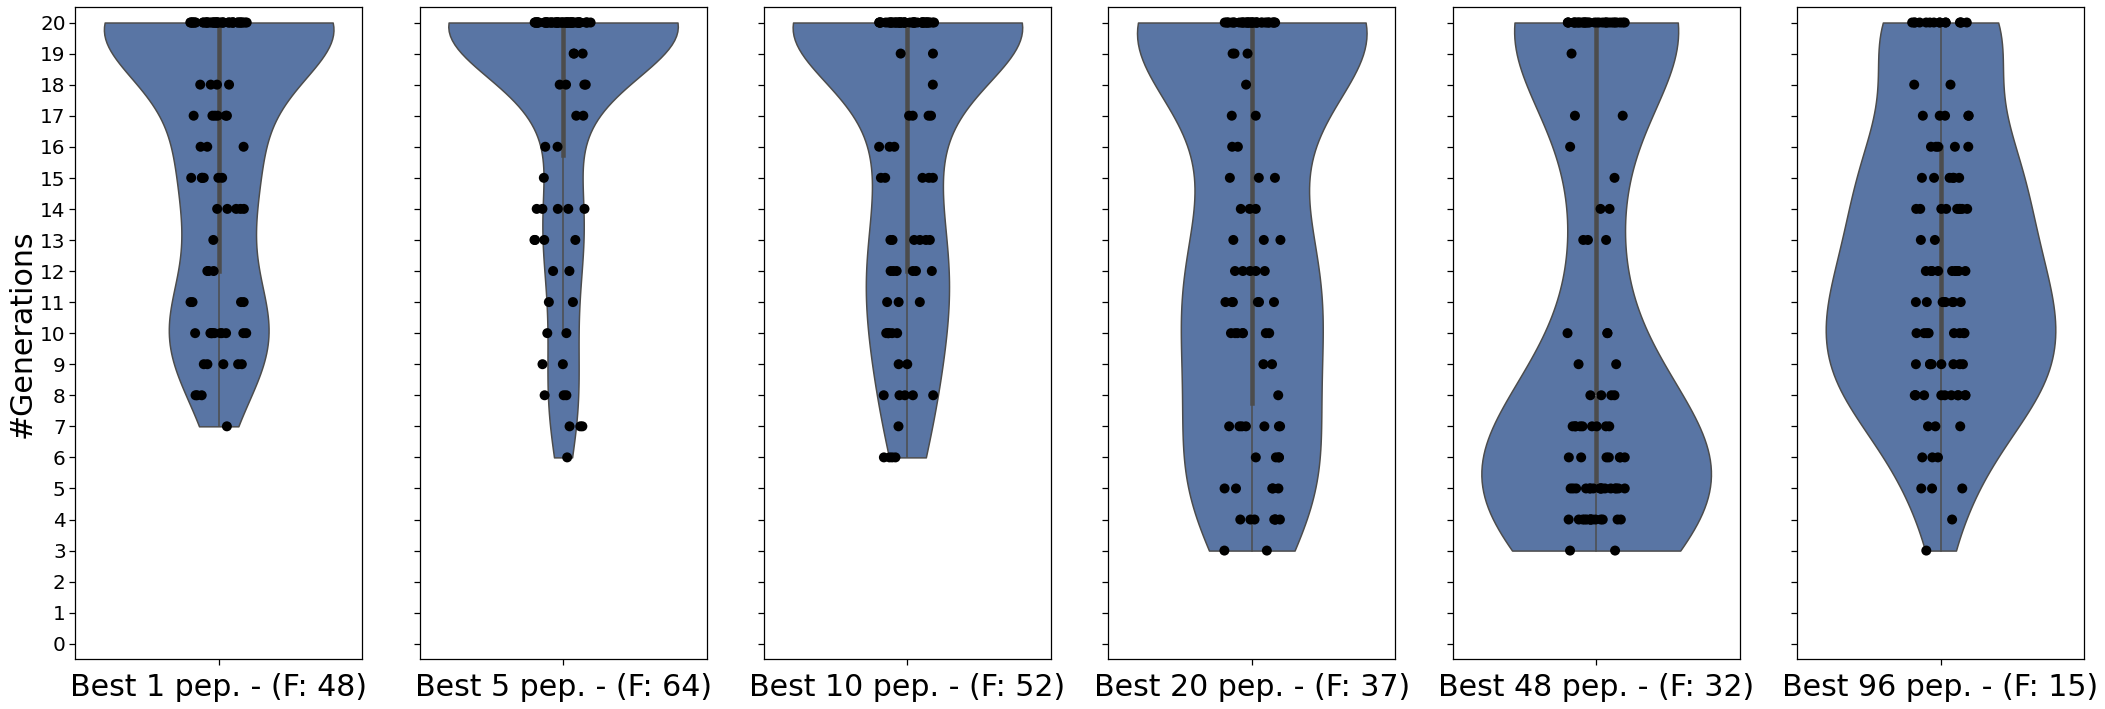

In [325]:
x_labels = ['Best %d pep.' % i for i in [1, 5, 10, 20, 48, 96]]
plot_distribution(logbooks, 'n_best', min_score, x_labels, 'figure_peptide_AAAAAA_n_best_weights_4.png')

## Repeated-motif peptide sequence

In [326]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('KRKRKR', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

KRKRKR
[0.]


In [328]:
NGEN = 20
NIND = 96

logbooks = []

for param in [1, 5, 10, 20, 48, 96]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=param, learning_rate=0.5, mut_prob=0.00)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['n_best'] = param
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

5: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

10: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

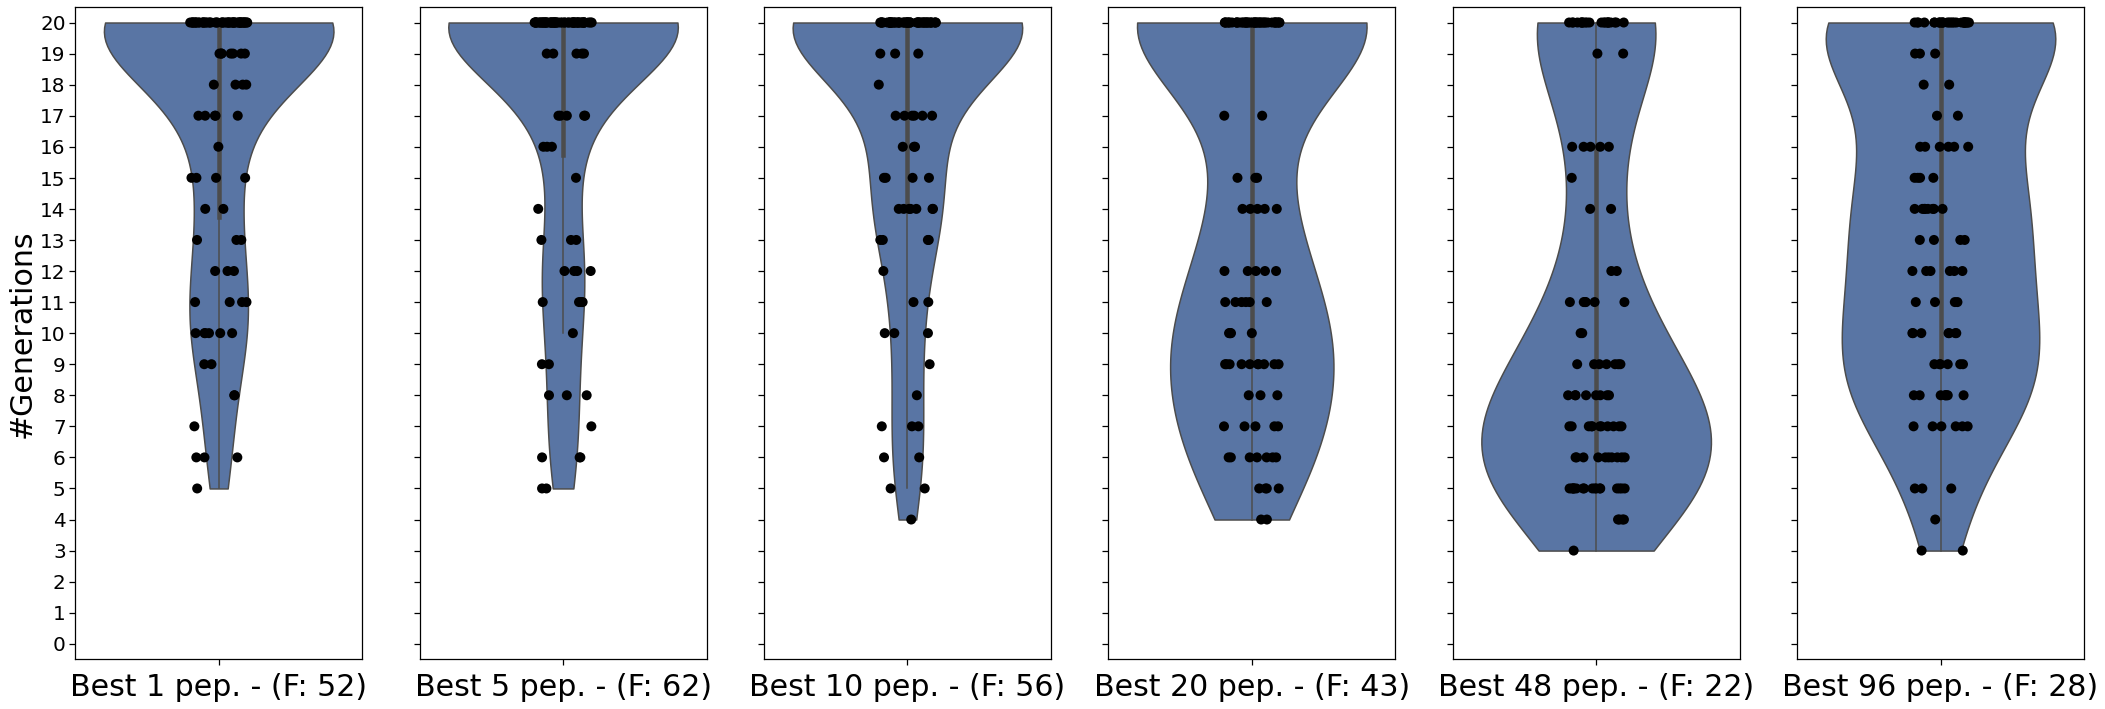

In [329]:
x_labels = ['Best %d pep.' % i for i in [1, 5, 10, 20, 48, 96]]
plot_distribution(logbooks, 'n_best', min_score, x_labels, 'figure_peptide_%s_n_best_weights.png' % target_sequence)

## Random peptide sequence

In [330]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
#vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

EWHINL
[0.43480894]


In [333]:
NGEN = 20
NIND = 96

logbooks = []

for param in [1, 5, 10, 20, 48, 96]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=param, learning_rate=0.5, mut_prob=0.00)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['n_best'] = param
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

5: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

10: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

20: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38

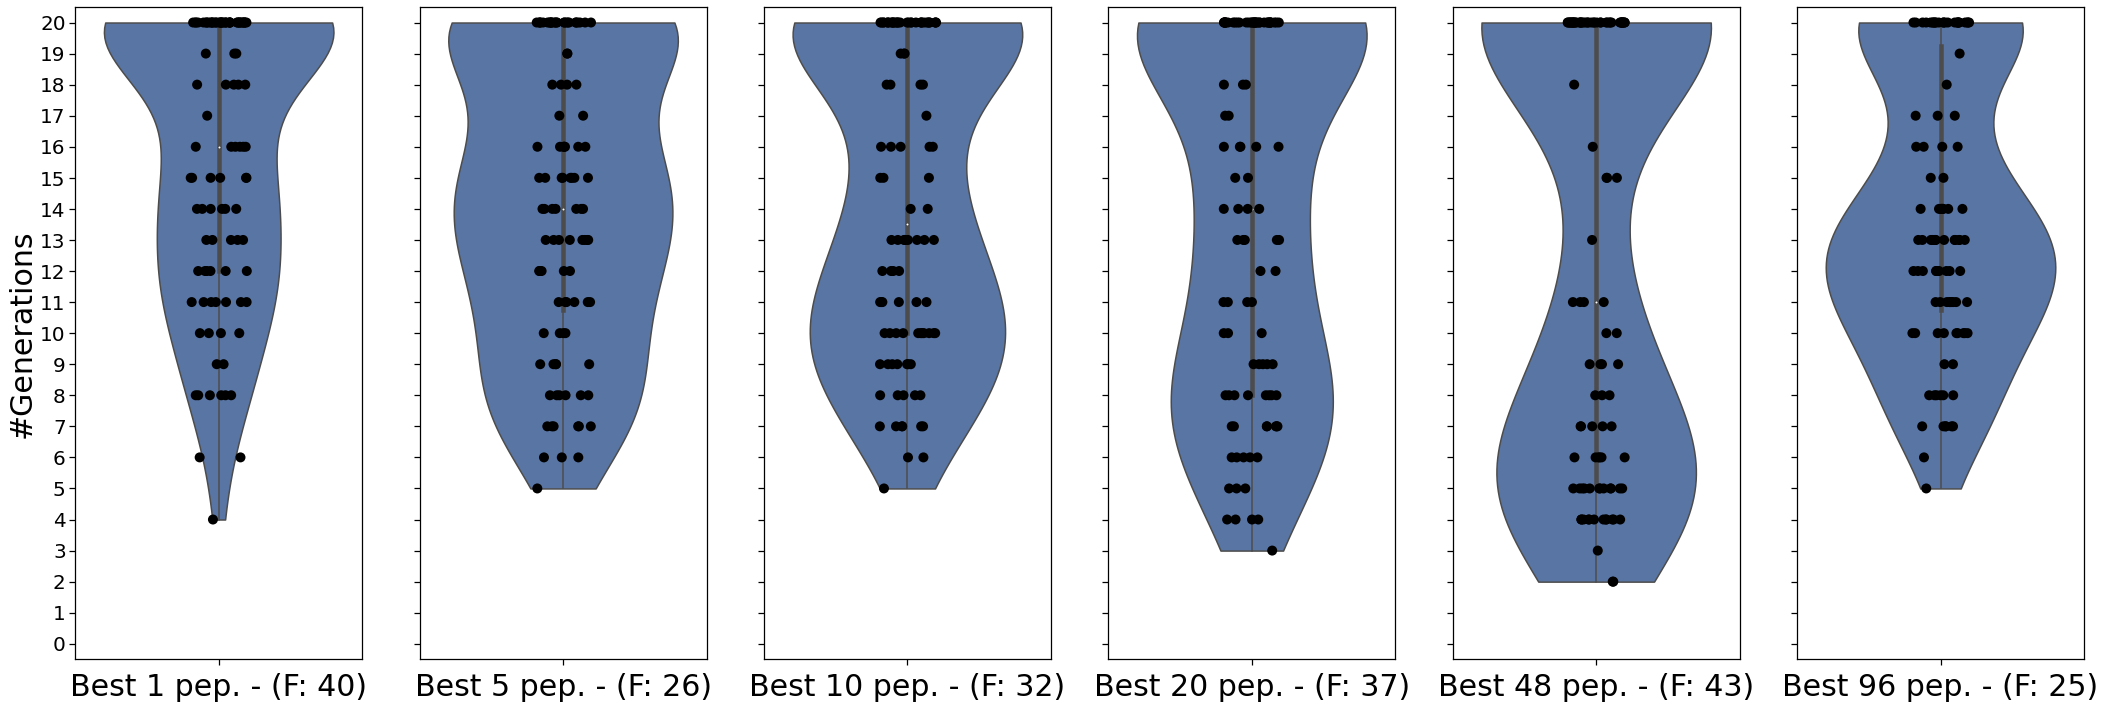

In [334]:
x_labels = ['Best %d pep.' % i for i in [1, 5, 10, 20, 48, 96]]
plot_distribution(logbooks, 'n_best', min_score, x_labels, 'figure_peptide_%s_n_best_weights.png' % target_sequence)

# Effect of sigma on the search

In [315]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

AAAAAA
[0.]


In [316]:
NGEN = 20
NIND = 96

logbooks = []

for sigma in [0.1, 0.2, 0.3, 0.4]:
    print(sigma)

    for i in range(100):
        print(i, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=48, learning_rate=0.5, 
                    sigma=sigma, mut_prob=0.00)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['sigma'] = sigma
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

0.1
0 

/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

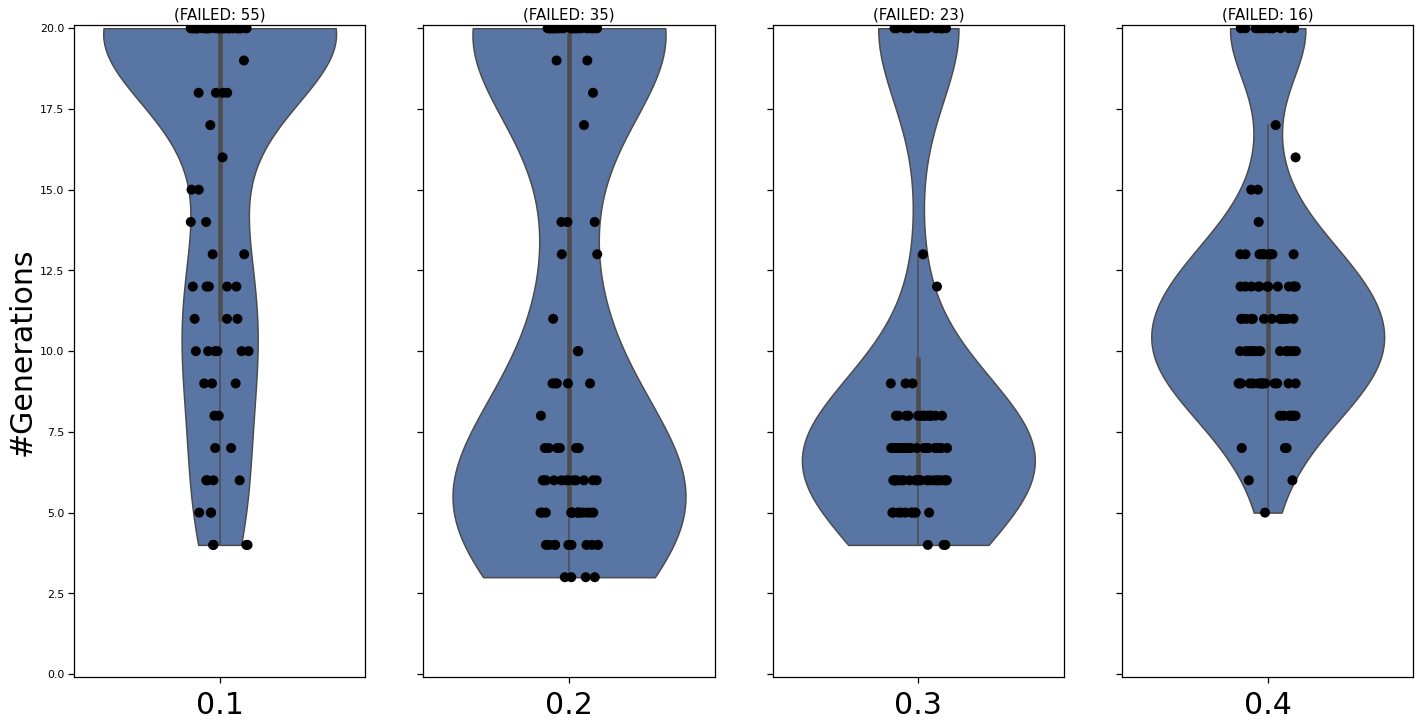

In [317]:
fig, axarr = plt.subplots(1, 4, figsize=(4*6, 12), sharey=True)

axarr[0].set_ylabel('#Generations', fontsize=30)

i = 0

for sigma_label, sigma_group in logbooks.groupby('sigma'):
    gens = []
    failed = 0

    for _, group in sigma_group.groupby('run'):
        best = group.sort_values(by=['min', 'gen']).iloc[0]
        gen = best['gen'] + 1 if best['min'] <= min_score else NGEN
        gens.append(gen)
        
        if gen == NGEN:
            failed += 1
        
    sns.set_theme(style=None)
    sns.violinplot(y=gens, cut=0, ax=axarr[i])
    sns.stripplot(y=gens, color='black', size=10, ax=axarr[i])
    axarr[i].set_title('(FAILED: %d)' % failed, fontsize=15)
    axarr[i].set_ylim([-0.1, NGEN + .1])
    axarr[i].set_xlabel(sigma_label, fontsize=30)
    
    i += 1

plt.savefig('figure_peptide_%s_n_best_weights_sigma.png' % target_sequence, dpi=300, bbox_inches='tight')
plt.show()

In [319]:
NGEN = 20
NIND = 96

logbooks = []

for sigma in [0.15, 0.2, 0.25]:
    print(sigma)

    for i in range(100):
        print(i, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=48, learning_rate=0.5, 
                    sigma=sigma, mut_prob=0.00)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['sigma'] = sigma
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

0.15
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

0.25
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 



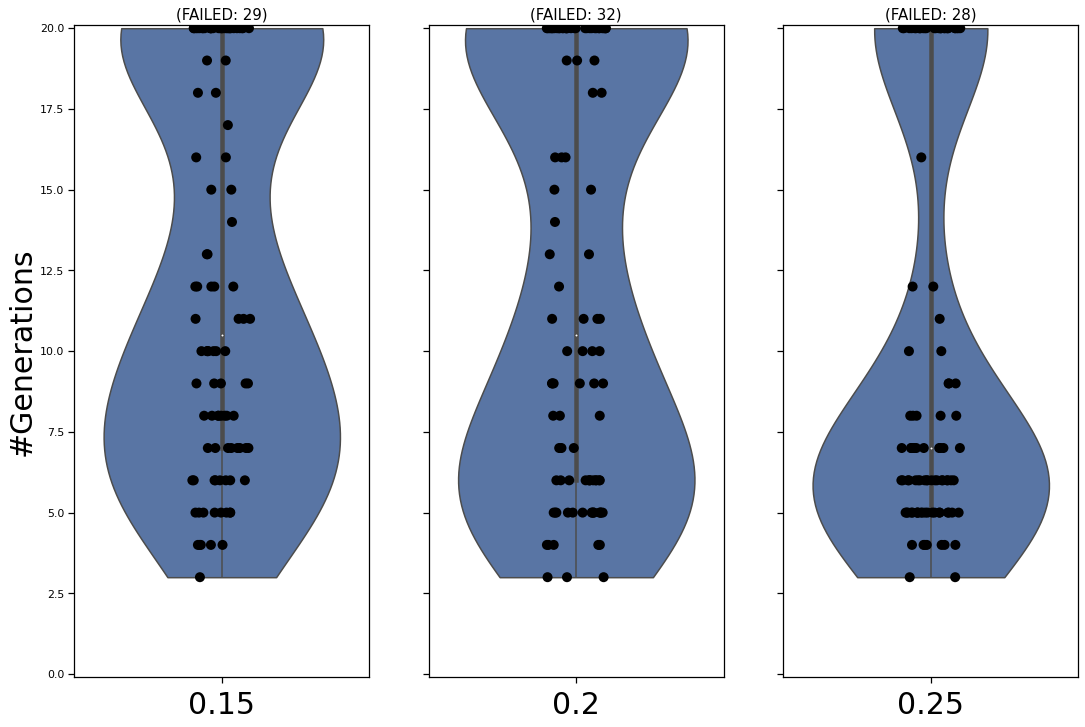

In [320]:
fig, axarr = plt.subplots(1, 3, figsize=(3*6, 12), sharey=True)

axarr[0].set_ylabel('#Generations', fontsize=30)

i = 0

for sigma_label, sigma_group in logbooks.groupby('sigma'):
    gens = []
    failed = 0

    for _, group in sigma_group.groupby('run'):
        best = group.sort_values(by=['min', 'gen']).iloc[0]
        gen = best['gen'] + 1 if best['min'] <= min_score else NGEN
        gens.append(gen)
        
        if gen == NGEN:
            failed += 1
        
    sns.set_theme(style=None)
    sns.violinplot(y=gens, cut=0, ax=axarr[i])
    sns.stripplot(y=gens, color='black', size=10, ax=axarr[i])
    axarr[i].set_title('(FAILED: %d)' % failed, fontsize=15)
    axarr[i].set_ylim([-0.1, NGEN + .1])
    axarr[i].set_xlabel(sigma_label, fontsize=30)
    
    i += 1

plt.savefig('figure_peptide_%s_n_best_weights_sigma_2.png' % target_sequence, dpi=300, bbox_inches='tight')
plt.show()

## Effect of the peptide length

### No warm up

In [340]:
NGEN = 20
NIND = 96

logbooks = []

ff = ForceField()
vt = VirtualTarget(ff)

for param in [4, 6, 8, 10, 12, 14]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')
        
        vt.generate_random_target_sequence(param)
        target_sequence = vt.target_sequence()
        target_score = vt.score_peptides([vt.target_sequence()])[0]

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=param, population_size=NIND, n_best=48, learning_rate=0.5, sigma=0.25)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['length'] = param
        df['target_score'] = target_score
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

8: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

10: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

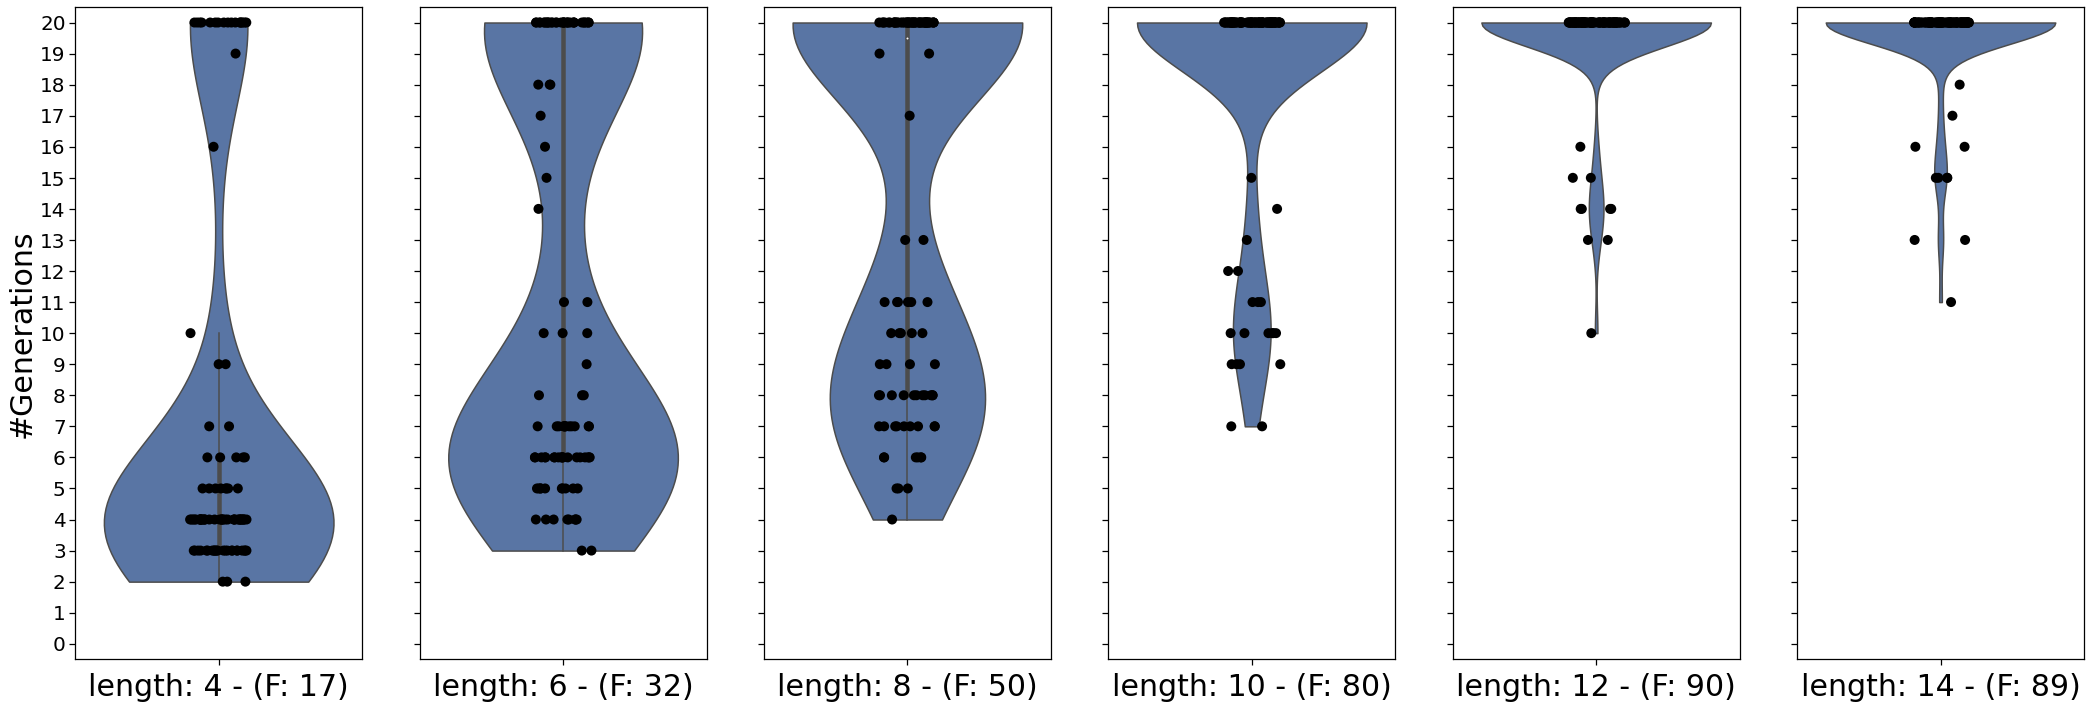

In [341]:
x_labels = ['length: %d' % i for i in [4, 6, 8, 10, 12, 14]]
plot_distribution(logbooks, 'length', x_labels, None, 'figure_peptide_48_n_best_length_nowarmup.png')

### With warm up (half residues of the target sequence are mutated)

In [337]:
NGEN = 20
NIND = 96

logbooks = []

ff = ForceField()
vt = VirtualTarget(ff)

for param in [4, 6, 8, 10, 12, 14]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')
        
        vt.generate_random_target_sequence(param)
        target_sequence = vt.target_sequence()
        target_score = vt.score_peptides([vt.target_sequence()])[0]

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=param, population_size=NIND, n_best=48, learning_rate=0.5, sigma=0.25)

        # Incorporate known data
        individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=int(param/2),
                                                                       maximum_mutations=int(param/2))
        scores = vt.score_peptides(individuals)
        pbil.update([list(ind) for ind in individuals], scores)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['length'] = param
        df['target_score'] = target_score
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

8: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

10: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

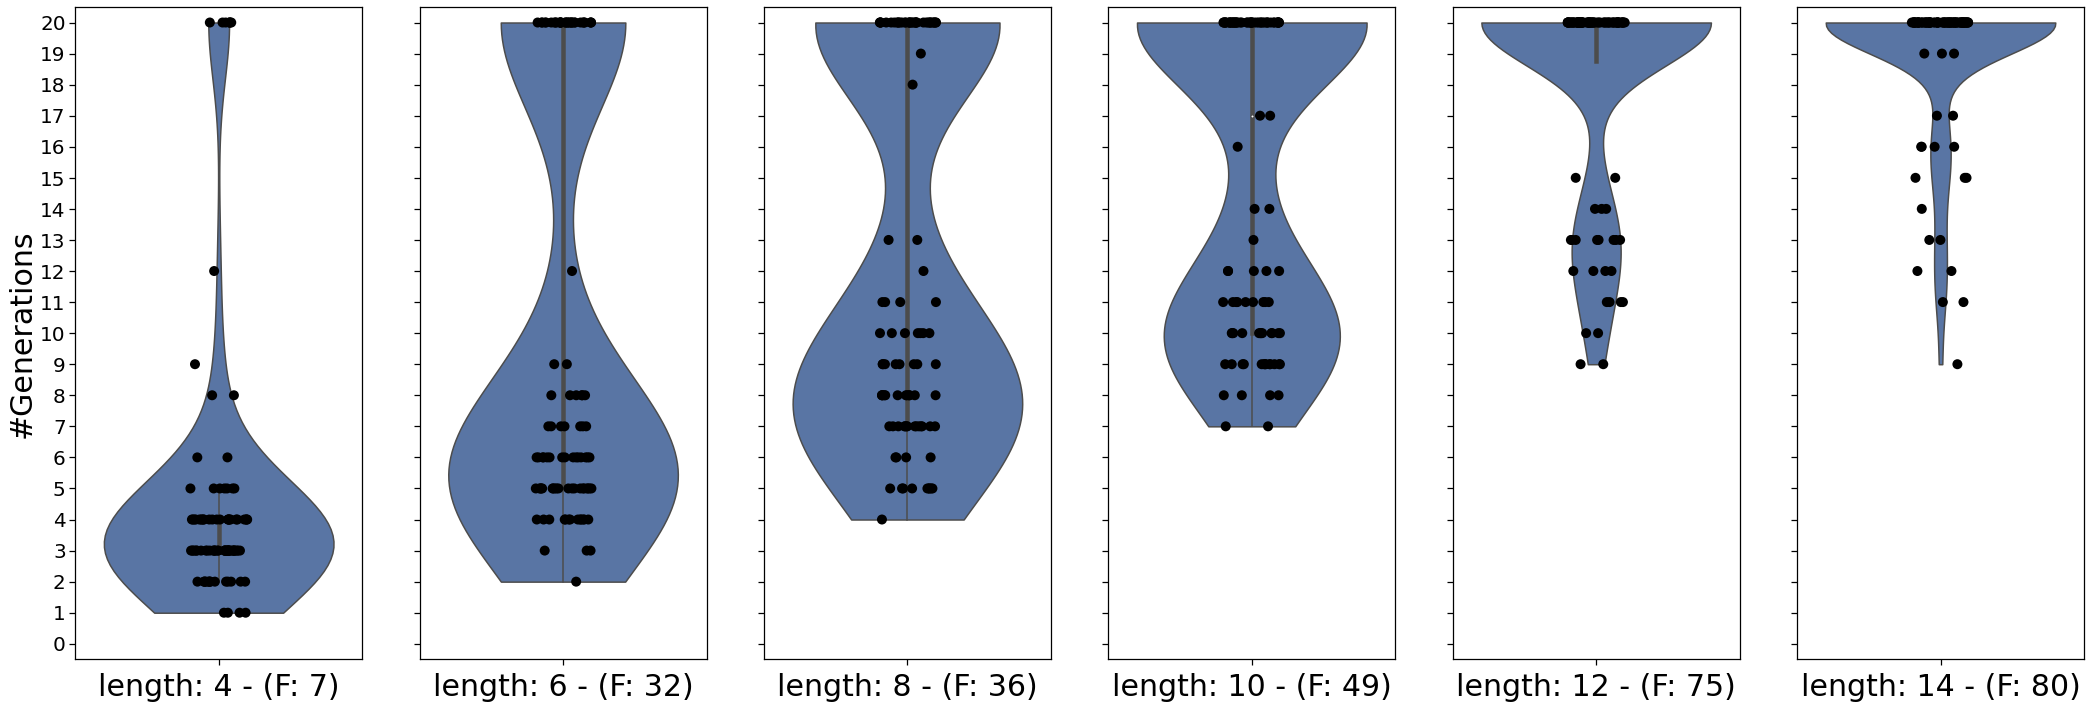

In [338]:
x_labels = ['length: %d' % i for i in [4, 6, 8, 10, 12, 14]]
plot_distribution(logbooks, 'length', x_labels, None, 'figure_peptide_48_n_best_length.png')

# Effect of the number of mutations (from the target sequence)

## Random peptide sequence

In [5]:
NLEN = 6
NGEN = 20
NIND = 96

logbooks = []

ff = ForceField()
vt = VirtualTarget(ff)

for param in range(1, NLEN + 1):
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')
        
        vt.generate_random_target_sequence(NLEN)
        target_sequence = vt.target_sequence()
        target_score = vt.score_peptides([vt.target_sequence()])[0]

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=48, learning_rate=0.5, sigma=0.25)

        # Incorporate known data
        individuals = vt.generate_random_peptides_from_target_sequence(1, minimum_mutations=param, 
                                                                       maximum_mutations=param)
        scores = vt.score_peptides(individuals)
        #print(np.min(scores))
        pbil.update([list(ind) for ind in individuals], scores)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['mutations'] = param
        df['target_score'] = target_score
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

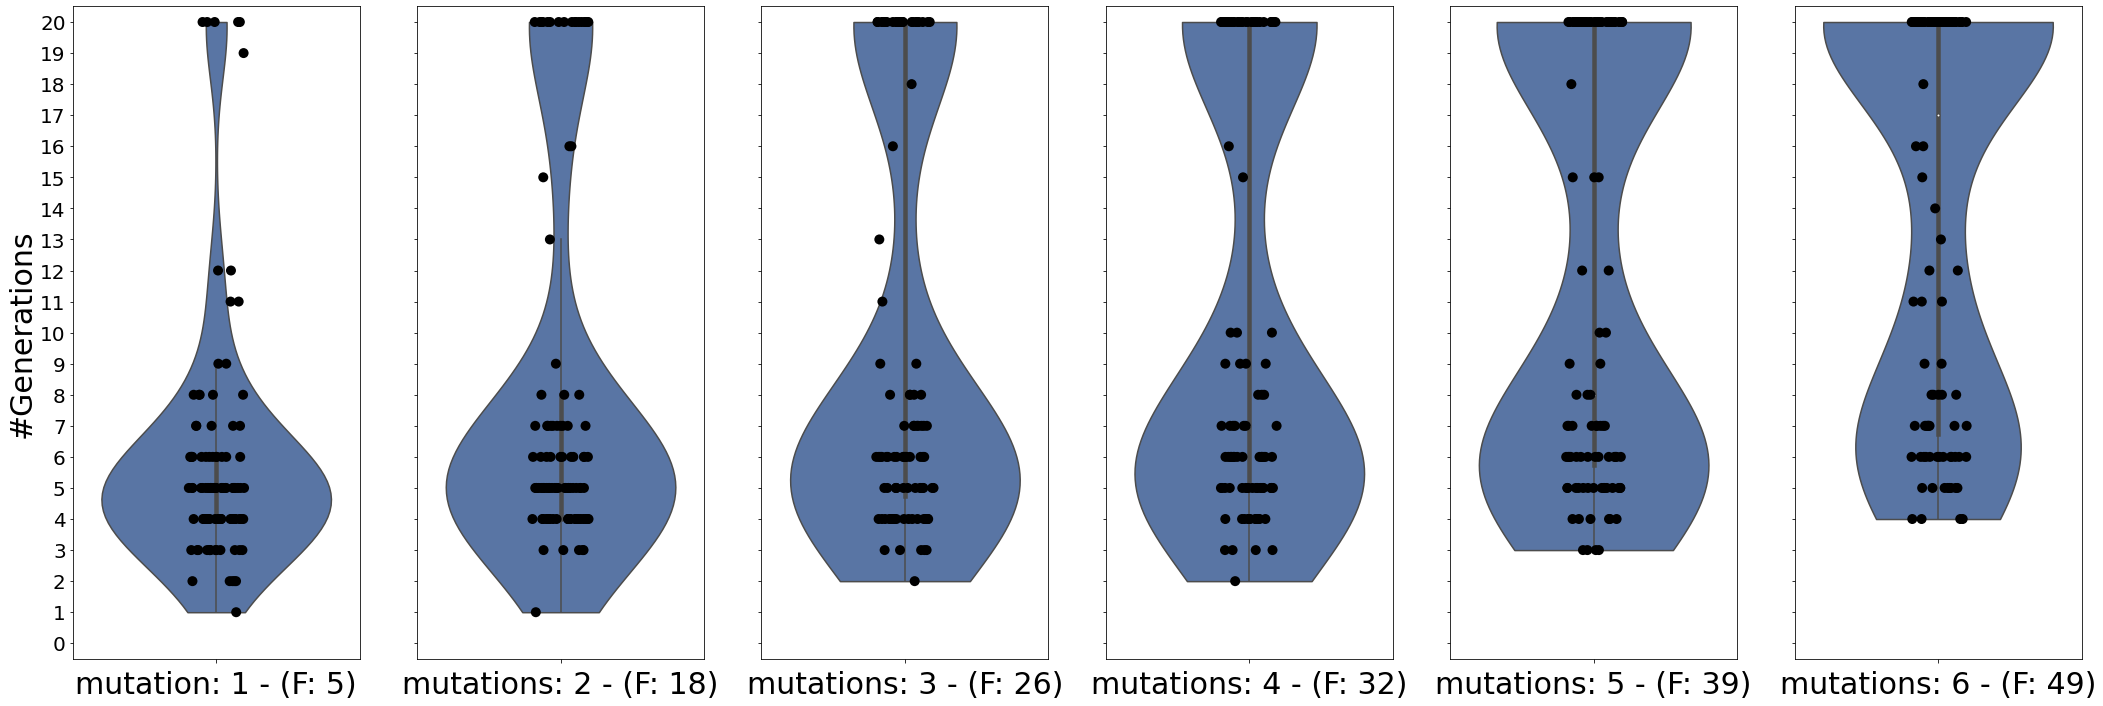

In [11]:
x_labels = ['mutation: 1'] + ['mutations: %d' % i for i in range(2, 7)]
plot_distribution(logbooks, 'mutations', x_labels, None, 'figure_peptide_48_n_best_mutations_nowarmup.png')

In [10]:
logbooks

,gen,nevals,avg,std,min,max,run,mutations,target_score
0,0,96,8.438825,2.604699,2.004775,15.627018,0,1,0.375228
1,1,96,6.133921,2.462774,1.499029,13.633203,0,1,0.375228
2,2,96,4.407362,2.076124,0.762829,10.198382,0,1,0.375228
3,3,96,3.159459,1.853328,0.762829,10.339102,0,1,0.375228
4,4,96,2.352437,1.603042,0.526500,6.429947,0,1,0.375228
...,...,...,...,...,...,...,...,...,...
15,15,96,0.847062,0.445438,0.697297,3.622196,99,6,0.651051
16,16,96,0.990161,0.762992,0.697297,5.169118,99,6,0.651051
17,17,96,0.970022,0.633136,0.697297,3.522256,99,6,0.651051
18,18,96,1.058258,0.788253,0.697297,3.741210,99,6,0.651051
